In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
import seaborn as sns
from category_encoders import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import tree, svm, ensemble
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import matplotlib.pyplot as pl
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
import scipy
%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline
os.chdir('/Users/axjx/Documents/cap')

In [2]:
data = pd.read_csv('data.csv')

Data Preprocessing

X1,X5,X12-X23 are  continuous variables; X2-X4,X6-X11 are categorial variables.

In [3]:
data = data.rename(index=str, columns={'X1':'Credit_Limit','X2':'Gender','X3':'Education',
'X4':'Marital_Status','X5':'Age','X6':'Repay_Status1','X7':'Repay_Status2','X8':'Repay_Status3','X9':'Repay_Status4','X10':'Repay_Status5',
'X11':'Repay_Status6','X12':'Bill_Amt1','X13':'Bill_Amt2','X14':'Bill_Amt3',
'X15':'Bill_Amt4','X16':'Bill_Amt5','X17':'Bill_Amt6','X18':'Pay_Amt1','X19':'Pay_Amt2','X20':'Pay_Amt3','X21':'Pay_Amt4','X22':'Pay_Amt5','X23':'Pay_Amt6','Y':'Defaulted'})

y = data['Defaulted']
X = data.drop(['Defaulted'], axis=1)
X.head(3)

,Credit_Limit,Gender,Education,Marital_Status,Age,Repay_Status1,Repay_Status2,Repay_Status3,Repay_Status4,Repay_Status5,...,Bill_Amt3,Bill_Amt4,Bill_Amt5,Bill_Amt6,Pay_Amt1,Pay_Amt2,Pay_Amt3,Pay_Amt4,Pay_Amt5,Pay_Amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000


In [4]:
#OneHotEncoding of Categorical Variables
categorical = ['Gender','Education','Marital_Status','Repay_Status1','Repay_Status2','Repay_Status3','Repay_Status4','Repay_Status5','Repay_Status6']
enc = OneHotEncoder(cols=categorical,drop_invariant=True).fit(X, y)
X = enc.transform(X)

#Continuous Variables - Normalize, Scaling 
numerical = ['Credit_Limit','Age','Bill_Amt1','Bill_Amt2','Bill_Amt3','Bill_Amt4','Bill_Amt5','Bill_Amt6','Pay_Amt1','Pay_Amt2','Pay_Amt3','Pay_Amt4','Pay_Amt5','Pay_Amt6']
#Normalize
X[numerical] = data[numerical].apply(lambda x: np.sign(x)*np.log(abs(x) +1))
#Scaling
scaler = MinMaxScaler()
X[numerical] = scaler.fit_transform(X[numerical])

If we chose a model that always predicted an individual had default = 1, what would that model's accuracy and F-score be on this dataset?

In [5]:
features_raw = data.drop('Defaulted', axis = 1)
y_actual = y
y_predict = np.ones(len(y))
accuracy = accuracy_score(y_actual, y_predict)
#Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(y_actual, y_predict, beta=0.5) 
print("Naive Predictor: [Accuracy score: {:.2f}, F-beta score: {:.2f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.22, F-beta score: 0.26]


In [8]:
features = X

Unbalanced Classes: Address with SMOTE

In [49]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, y, test_size=.25, random_state=12)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = .25, random_state=12)

sm = SMOTE(random_state=12, ratio = 'auto')
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
x_train_res = pd.DataFrame(x_train_res, columns = x_train.columns)
n_default_res = y_train_res[y_train_res == 1].shape[0]
default_res_percent = float(n_default_res)/float(y_train_res.size)*100
print("Number of Samples after SMOTE: training: {}, validation: {}, testing: {}"
      .format(x_train_res.shape[0], x_val.shape[0], x_test.shape[0]))
print("Percentage of individuals who defaulted in the train set after SMOTE: {:.2f}%".format(default_res_percent))

No. of samples in each subset after SMOTE: training = 26306, validation = 5625, testing= 7500
% of individuals who are defaulted in the training set after SMOTE: 50.00%


Predictive Modeling

In [50]:
def train_predict(learner, X_train, y_train, X_val, y_val): 
    results = {}
    learner = learner.fit(X_train, y_train)
    predictions_train = learner.predict(X_train)
    predictions_val = learner.predict(X_val)
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['f_val'] = fbeta_score(y_val, predictions_val, beta=0.5)
    print("\n{} training results:".format(learner.__class__.__name__))
    print("\tTraining accuracy: {:.2f}".format(results['acc_train']))
    print("\n\tTraining F-beta score: {:.2f}".format(results['f_train']))
    print("\n\tValidation accuracy: {:.2f}".format(results['acc_val']))
    print("\n\tValidation F-beta score: {:.2f}".format(results['f_val']))

Two Methods: AdaBoost and SVM

In [51]:
clf_1 = AdaBoostClassifier(random_state=12)
clf_2= svm.SVC(random_state=12)

for clf in [clf_1, clf_2]:
    train_predict(clf, x_train_res, y_train_res, x_val, y_val)


AdaBoostClassifier training results:
	Training accuracy: 0.74

	Training F-beta score: 0.76

	Validation accuracy: 0.76

	Validation F-beta score: 0.49

SVC training results:
	Training accuracy: 0.71

	Training F-beta score: 0.73

	Validation accuracy: 0.79

	Validation F-beta score: 0.53


In [52]:
def fine_tune_model(X_train, y_train, X_val, y_val):
    clf = AdaBoostClassifier(random_state = 1)
    parameters = {'n_estimators' : [50,75,100,200], 'learning_rate' : [0.5,0.8,1,1.2]}
    scorer = make_scorer(fbeta_score, beta= 0.5)
    search_obj = GridSearchCV(clf, parameters, scoring=scorer)
    search_fit = search_obj.fit(X_train, y_train)
    print("Best parameters: ", search_fit.best_params_)
    print()
    best_clf = search_fit.best_estimator_
    predictions = (clf.fit(X_train, y_train)).predict(X_val)
    best_predictions = best_clf.predict(X_val)
    print("Unoptimized model\n------")
    print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
    print("F-beta score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
    print("F-beta score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))
    return best_clf

best_clf = fine_tune_model(x_train_res, y_train_res, x_val, y_val)

Best parameters:  {'learning_rate': 1.2, 'n_estimators': 200}

Unoptimized model
------
Accuracy score on validation data: 0.7630
F-beta score on validation data: 0.4889

Optimized Model
------
Accuracy score on validation data: 0.7742
F-beta score on validation data: 0.4977


In [53]:
final_best_predictions = best_clf.predict(x_test)
print("Accuracy score on unseen test data: {:.2f}".format(accuracy_score(y_test, final_best_predictions)))
print("F-beta score on unseen test data: {:.2f}".format(fbeta_score(y_test, final_best_predictions, beta = 0.5)))

Accuracy score on unseen test data: 0.77
F-beta score on unseen test data: 0.49


Model Evaluation

The unoptimized and optimized models performed better than the benchmark Naive predictor.

The optimized model also performed  better than the unoptimized model for both the accuracy scores and F-scores.

In [54]:
def plot_roc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    lw=2
    pl.figure()
    pl.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc))
    pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    pl.xlabel('False positive rate')
    pl.ylabel('True positive rate')
    pl.title('Receiver Operating Characteristics (ROC) curve')
    pl.legend(loc="lower right")
    pl.show()

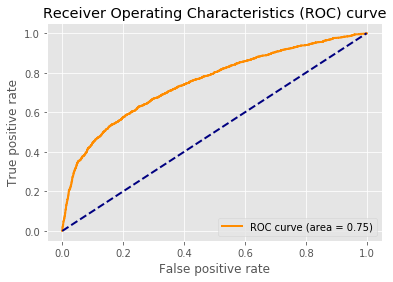

In [55]:
y_pred_proba = best_clf.predict_proba(x_test)[:, 1]
plot_roc(y_test, y_pred_proba)

In [56]:
def feature_plot(importances, X_train, y_train):
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

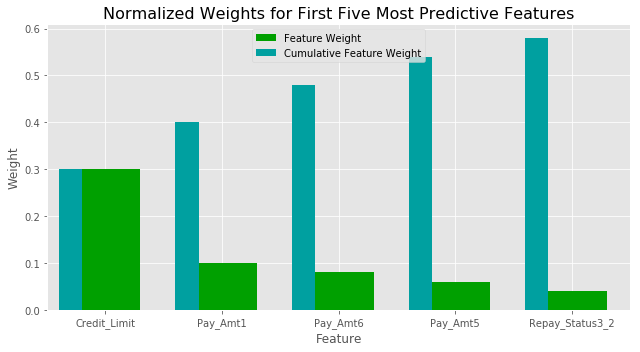

In [59]:
clf = AdaBoostClassifier(random_state = 1)
model = clf.fit(x_train_res, y_train_res)
importances = model.feature_importances_
feature_plot(importances, x_train_res, y_train_res)

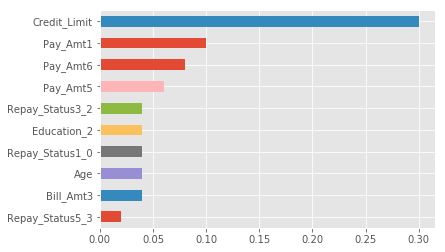

In [82]:
n = 10
fi = model.feature_importances_
pd.Series(fi, index=x_train_res.columns).sort_values()[-n:].plot(kind='barh');

Feature Selection

In [81]:
from sklearn.base import clone
X_train_reduced = x_train_res[x_train_res.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = x_val[x_val.columns.values[(np.argsort(importances)[::-1])[:5]]]
clf = (clone(best_clf)).fit(X_train_reduced, y_train_res)

reduced_predictions = clf.predict(X_test_reduced)
best_predictions = best_clf.predict(x_val)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_val, reduced_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7742
F-score on testing data: 0.4977

Final Model trained on reduced data
------
Accuracy on testing data: 0.7262
F-score on testing data: 0.4008


The final model trained on full data outperformed the final model trained on reduced data.